https://archive.ics.uci.edu/dataset/186/wine+quality

In [1]:
# set up Python
import logging
import numpy as np
import pandas as pd
import json
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from plotnine import *

In [2]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
wine_data = wine_quality.data.features 
wine_targets = wine_quality.data.targets 

In [3]:
wine_data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [4]:
wine_targets['quality'].value_counts()


quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [5]:
# build preference we are trying to learn
taste_model = LogisticRegression(max_iter=10000)
taste_model.fit(wine_data, wine_targets['quality'] >= 7)
beta = taste_model.coef_[0]

beta

array([ 9.82689316e-02, -3.97240746e+00, -3.36942780e-01,  5.94024936e-02,
       -2.47219443e+00,  1.26612867e-02, -3.87848066e-03, -1.43901908e-01,
        7.73691605e-01,  1.49234318e+00,  9.45871470e-01])

In [6]:
wine_scores = pd.DataFrame({
    'score': wine_data @ beta,
    'quality_ge_7': [int(v) for v in wine_targets['quality'] >= 7],
    'quality': wine_targets['quality'],
    })

wine_scores

,score,quality_ge_7,quality
0,10.177865,0,5
1,9.856330,0,5
2,10.241983,0,5
3,12.145984,0,6
4,10.177865,0,5
...,...,...,...
6492,13.350304,0,6
6493,11.746045,0,5
6494,11.288781,0,6
6495,14.241046,1,7


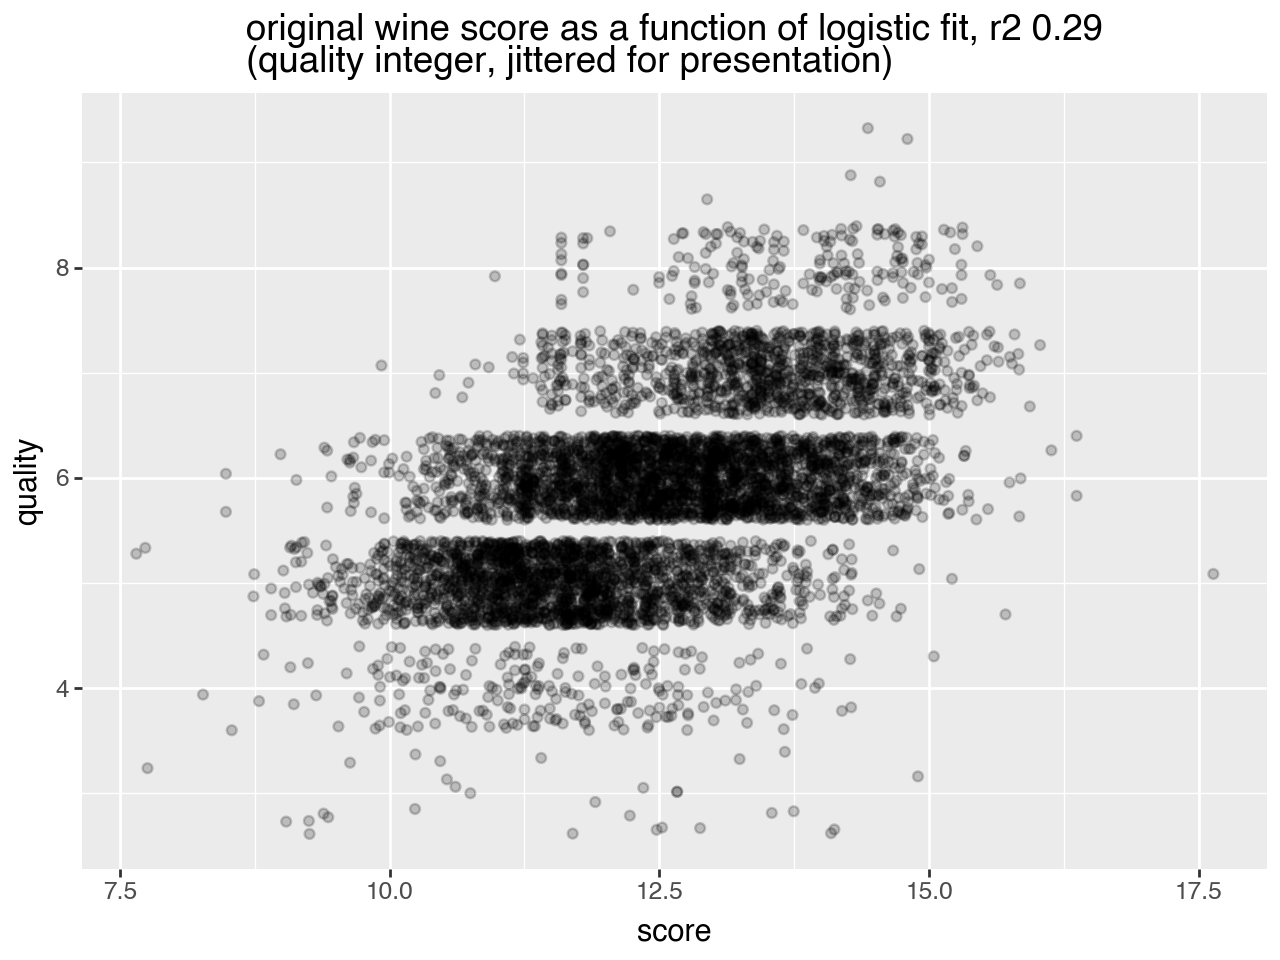

In [7]:
lin_model_test = LinearRegression()
lin_model_test.fit(
    wine_scores.loc[:, ['score']],
    wine_scores.loc[:, 'quality'],
)
r2 = r2_score(
    y_true=wine_scores.loc[:, 'quality'],
    y_pred=lin_model_test.predict(wine_scores.loc[:, ['score']]),
)
(
    ggplot(
        data=wine_scores,
        mapping=aes(x='score', y='quality'),
    )
    + geom_point(alpha=0.2, position='jitter')
    + ggtitle(f"original wine score as a function of logistic fit, r2 {r2:.2f}\n(quality integer, jittered for presentation)")
)

In [8]:
# save 
wine_data.to_csv('uci_wine_example_features.csv', index=False)
wine_scores.to_csv('uci_wine_example_scores.csv', index=False)